Analyzing hOCR data
-------------------------

In [1]:
from hOCRpy import hOCR
from hOCRpy import bbox_plot, lm_model, cluster_plot, predict_columns
import numpy as np

### Overall page layout

Given the following page

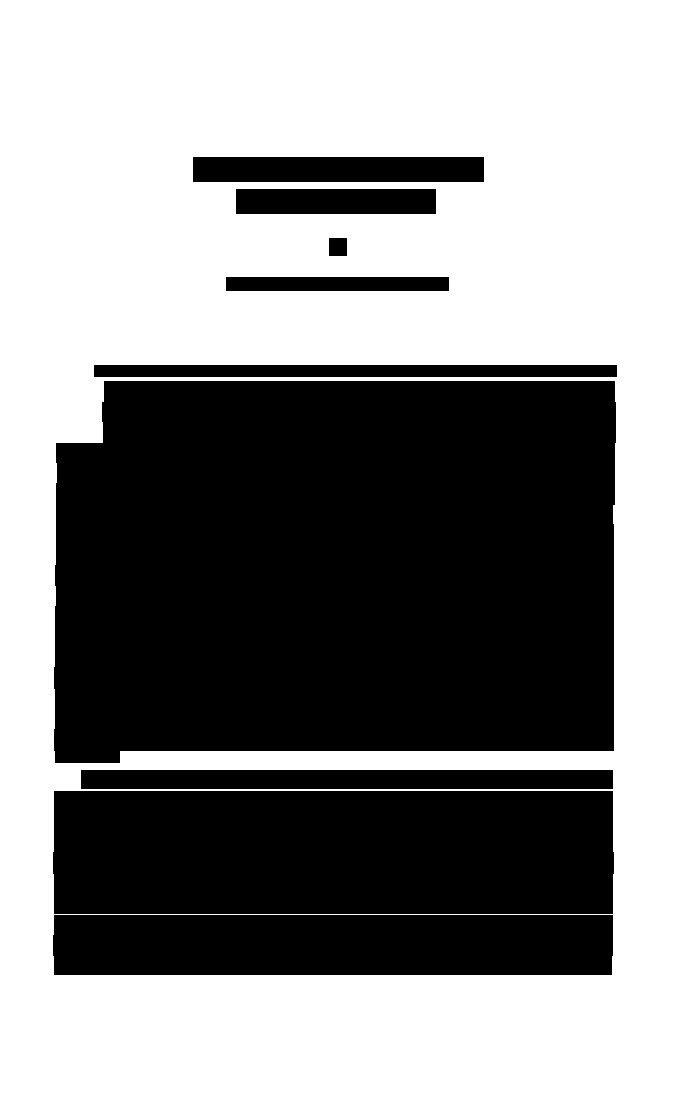

In [2]:
one_col_path = 'examples/hocr/one_column.hocr'
one_col = hOCR(one_col_path)
one_col.show_structure(which='line', return_image=True)

We can find out some key information about the page format, including whether the page contains multiple columns. Bounding box data tells us where a particular token lies on a page, and we can plot this information.

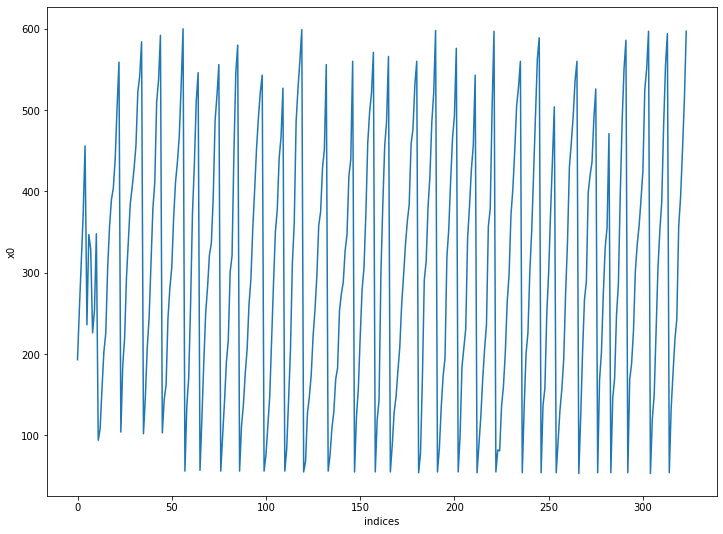

In [3]:
bbox_plot(one_col, x='indices', y='x0', regression_line=False)

In the plot above, the y axis represents where a token sits with respect to page width.

It's also possible to plot the token's height, but this tends not to be as informative.

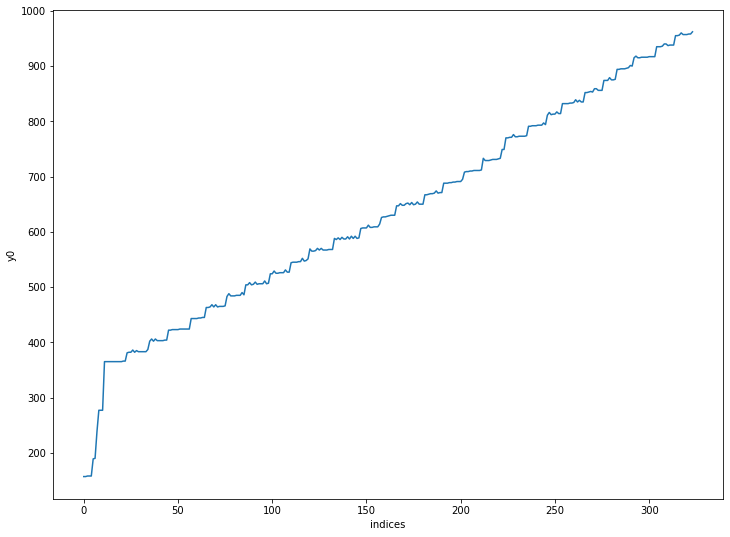

In [4]:
bbox_plot(one_col, x='indices', y='y0', regression_line=False)

You may have noticed a `regression_line` argument. If we set this to `True`, we can fit a least-squares regression model to the bounding boxes (the package uses `SciPy`'s `linregress`). This works best if we use the bounding boxes' index position as a constant and ask the model to predict on boxes' positions.

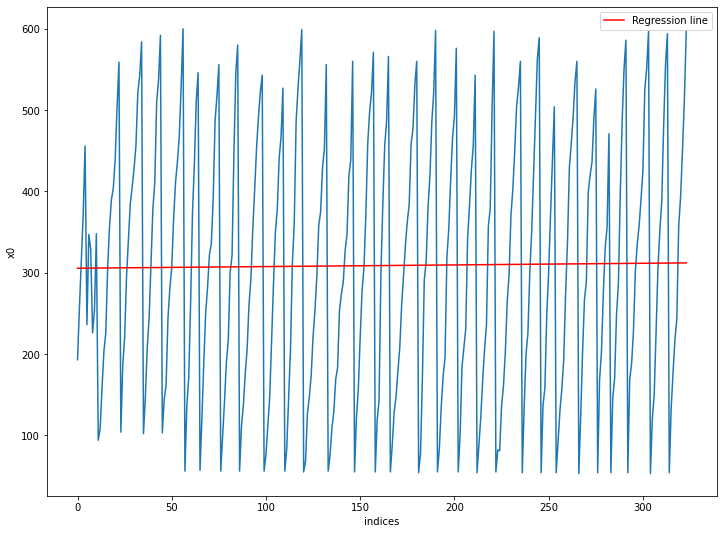

In [5]:
bbox_plot(one_col, x='indices', y='x0', regression_line=True)

The more standard the page layout, the flatter a regression line is likely to be.

`hOCRpy` also lets you access the model directly. Note that the default values for `x` and `y` are `indices` and `x0`, respectively. These values tend to produce the best results.

In [6]:
lm = lm_model(one_col, x='indices', y='x0')
print(
    f"Slope: {lm.slope}",
    f"\nIntercept: {lm.intercept}",
    f"\nR value: {lm.rvalue}",
    f"\nP value: {lm.pvalue}",
    f"\nStandard error: {lm.stderr}",
    f"\nIntercept standard error: {lm.intercept_stderr}"
)

Slope: 0.020285429511435707 
Intercept: 305.54180436847105 
R value: 0.011680238799808543 
P value: 0.8341056500555435 
Standard error: 0.09677761673479725 
Intercept standard error: 18.0614535768228


### Column prediction

If we load a two-column page, this all becomes much more interesting.

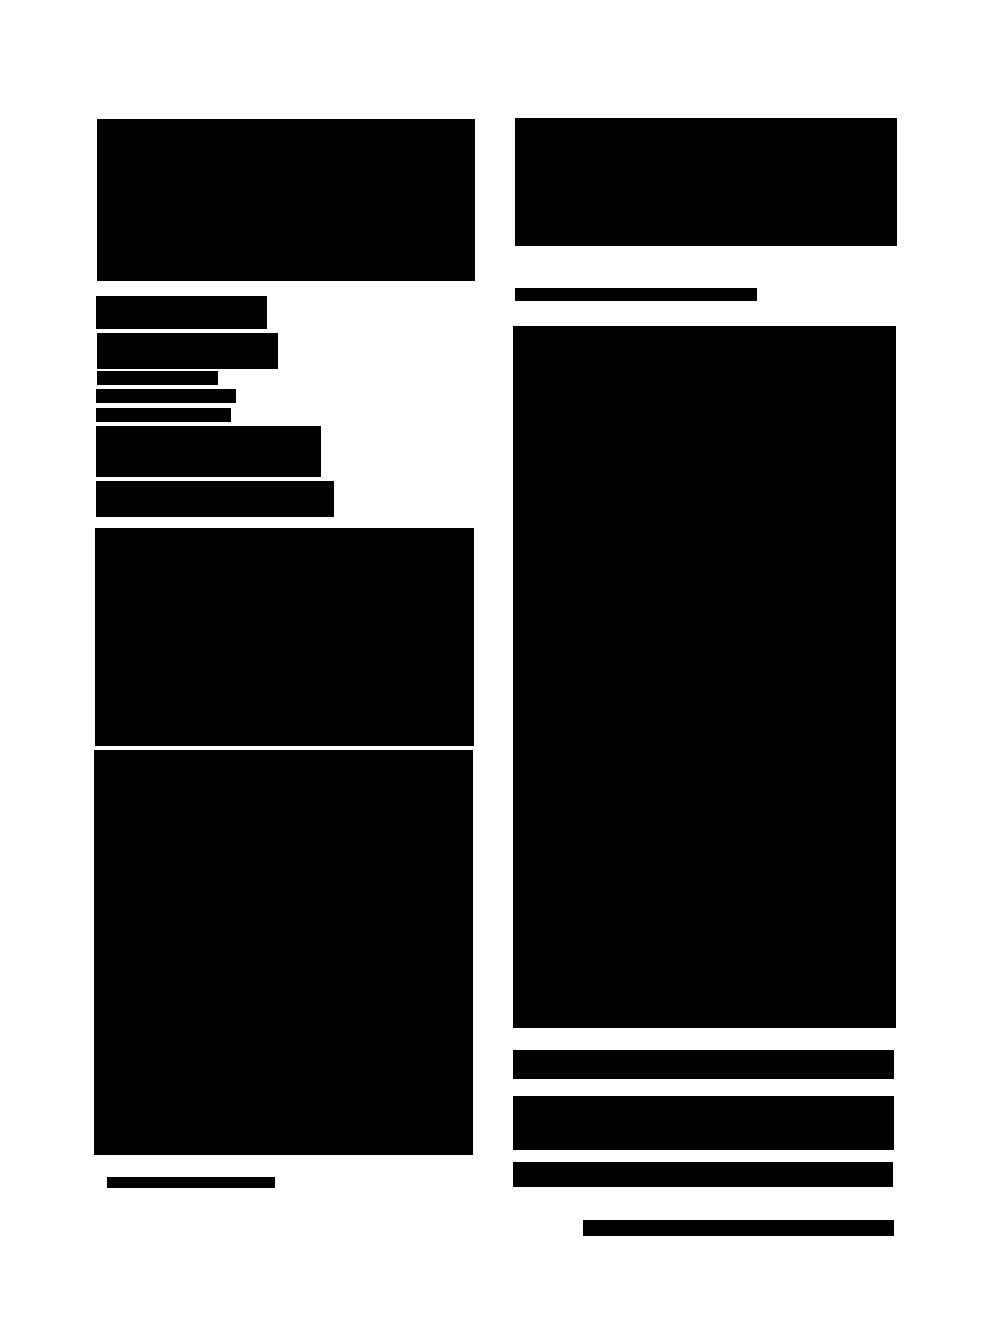

In [7]:
two_col_path = 'examples/hocr/two_column.hocr'
two_col = hOCR(two_col_path)
two_col.show_structure(which='paragraph', return_image=True)

Here's the bounding box plot for the above.

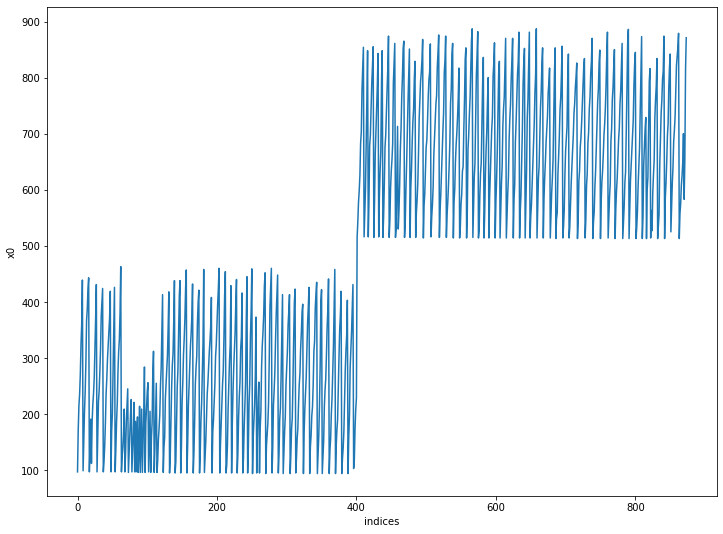

In [8]:
bbox_plot(two_col, x='indices', y='x0', regression_line=False)

See the jump? That's an indication that there is more than one column on this page. With `cluster_plot()`, we can fit a k-means clusterer to the bounding box data and demonstrate this separation.

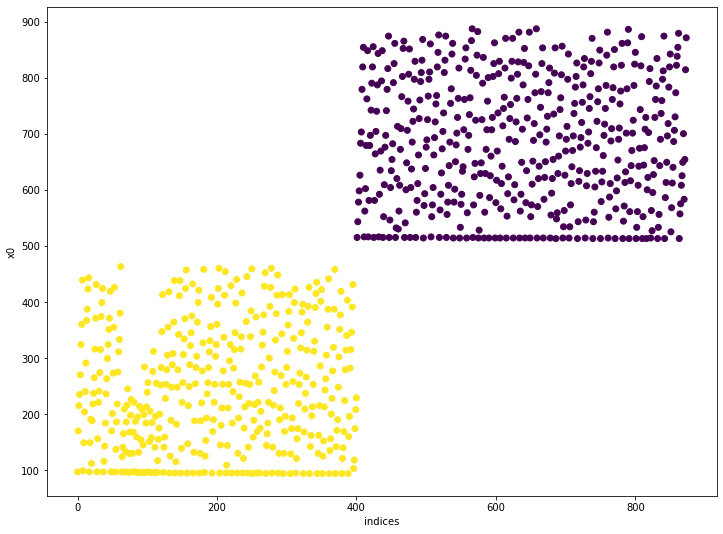

In [19]:
cluster_plot(two_col, 2, dim1='indices', dim2='x0')

`predict_columns()` will validate the k-means clusters using a silhouette score to find the optimal number of clusters for a page. If you use `x0`, each such cluster corresponds to a predicted column.

In [10]:
predict_columns(two_col, max_k=5, dim1='indices', dim2='x0')

Column prediction
-----------------
Silhouette Scores: {2: 0.6666884198101901, 3: 0.49384512352867294, 4: 0.39410166094788424}
Best k: 2

Running a linear model on the two-column page gives the following:

In [11]:
lm2 = lm_model(two_col, x='indices', y='x0')
print(
    f"Slope: {lm2.slope}",
    f"\nIntercept: {lm2.intercept}",
    f"\nR value: {lm2.rvalue}",
    f"\nP value: {lm2.pvalue}",
    f"\nStandard error: {lm2.stderr}",
    f"\nIntercept standard error: {lm2.intercept_stderr}"
)

Slope: 0.7556814492528947 
Intercept: 153.58555083360574 
R value: 0.7787340502199698 
P value: 9.354273548463611e-179 
Standard error: 0.02061598817929574 
Intercept standard error: 10.393985477295686


If we take the R squared values of both models, we'll see that the one-column page has far less variance. You can use this difference as another way to determine format.

In [12]:
lm.rvalue ** 2 < lm2.rvalue ** 2

True

Finally, here's a three-column page.

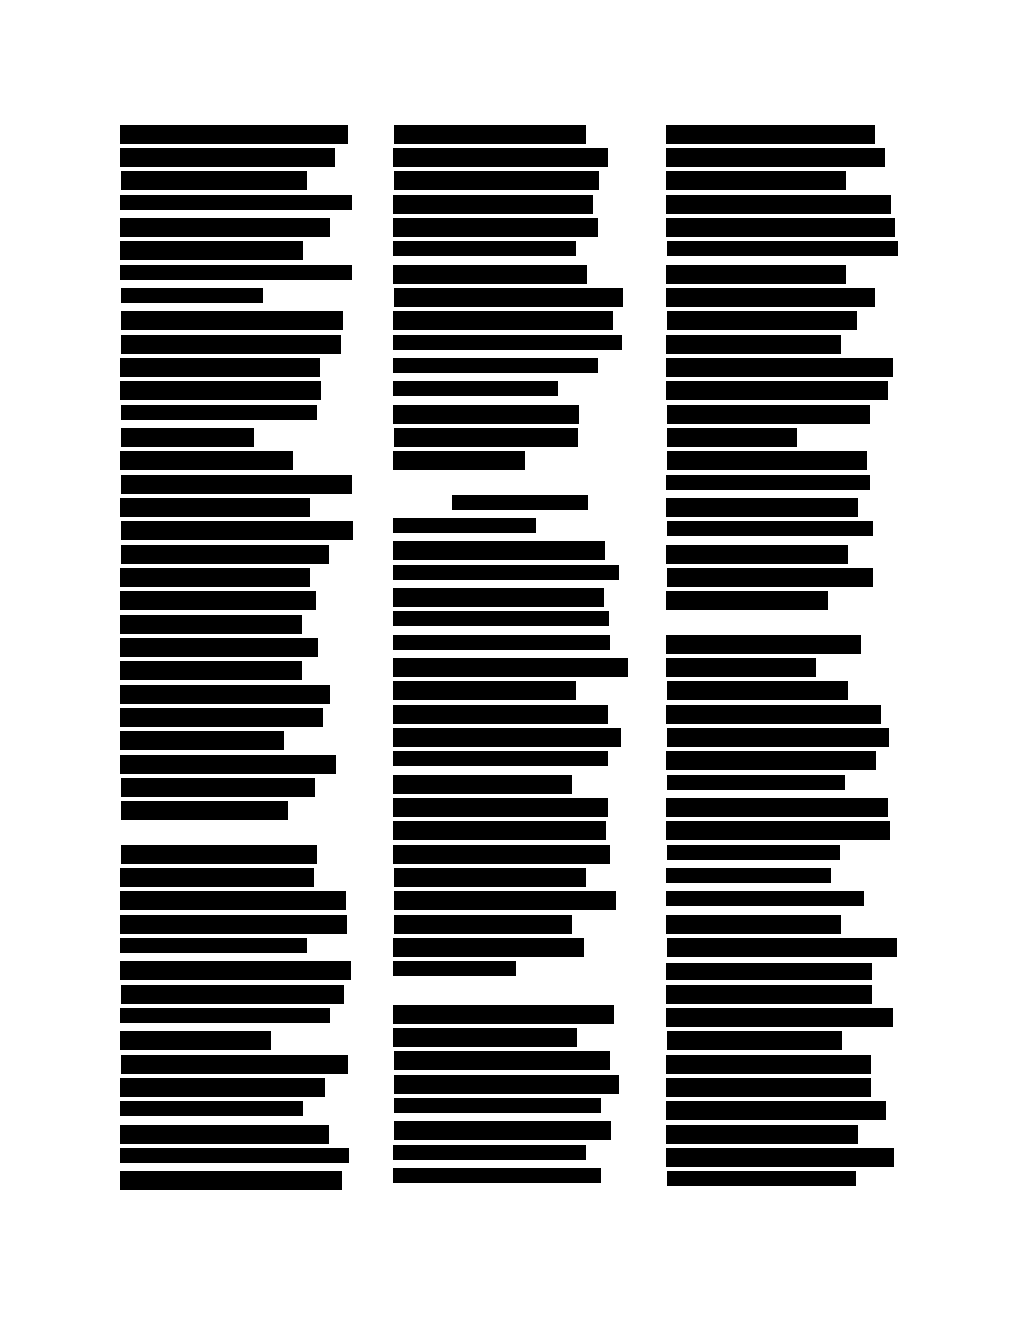

In [13]:
three_col_path = 'examples/hocr/three_column.hocr'
three_col = hOCR(three_col_path)
three_col.show_structure(which='line', return_image=True)

In [14]:
predict_columns(three_col, max_k=5, dim1='indices', dim2='x0')

Column prediction
-----------------
Silhouette Scores: {2: 0.6138446427165902, 3: 0.6898576220431595, 4: 0.5372820387753436}
Best k: 3

Assign the output of `predict_columns()` to get a container that holds each of the respective k clusters' silhoutte scores, the best k, and the cluster labels for each token on the page.

In [15]:
results = predict_columns(three_col, max_k=5, dim1='indices', dim2='x0')
np.unique(results.labels)

array([0, 1, 2])

### Aligning text to columns

With the tokens labeled, it's possible to split out the text data into each column using `hOCR`'s `.text_to_column()` method.

In [16]:
columns = three_col.text_to_column(results.labels)
for col in columns:
    print(f"Column {col}:", ' '.join(columns[col][:10]))

Column 0: Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do
Column 2: sed vulputate odio. Sem fringilla ut morbi tincidunt augue interdum
Column 1: non arcu risus quis varius. Odio aenean sed adipiscing diam


In [25]:
type(one_col.show_page(return_image=True))

PIL.Image.Image